<a href="https://colab.research.google.com/github/Prakharprasun/Surface-Defect-Classification/blob/main/Surface_Defects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# Define class order manually
class_order = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

In [88]:
import os
import shutil

# Original paths
train_dir = '/content/drive/MyDrive/ML Datasets/NEU-DET/train/images'
val_dir = '/content/drive/MyDrive/ML Datasets/NEU-DET/validation/images'

# New merged path
merged_dir = '/content/drive/MyDrive/ML Datasets/NEU-DET/merged/images'
os.makedirs(merged_dir, exist_ok=True)

# Class names (ensure they exist in both)
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

for class_name in class_names:
    merged_class_dir = os.path.join(merged_dir, class_name)
    os.makedirs(merged_class_dir, exist_ok=True)

    # Copy from train
    train_class_dir = os.path.join(train_dir, class_name)
    if os.path.exists(train_class_dir):
        for filename in os.listdir(train_class_dir):
            shutil.copy(os.path.join(train_class_dir, filename), merged_class_dir)

    # Copy from val
    val_class_dir = os.path.join(val_dir, class_name)
    if os.path.exists(val_class_dir):
        for filename in os.listdir(val_class_dir):
            shutil.copy(os.path.join(val_class_dir, filename), merged_class_dir)

print("✅ All files merged into:", merged_dir)

✅ All files merged into: /content/drive/MyDrive/ML Datasets/NEU-DET/merged/images


In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# New path
merged_path = '/content/drive/MyDrive/ML Datasets/NEU-DET/merged/images'

# Augmentations + split
data_gen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [90]:
train_data = data_gen.flow_from_directory(
    merged_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 1465 images belonging to 6 classes.


In [91]:
val_data = data_gen.flow_from_directory(
    merged_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 365 images belonging to 6 classes.


In [92]:
print("Train indices:", train_data.class_indices)
print("Val indices:", val_data.class_indices)

Train indices: {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}
Val indices: {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


In [93]:
# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

In [94]:
# Unfreeze more layers for fine-tuning
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [95]:
# Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(class_order), activation='softmax')  # Use 'sigmoid' for multi-label classification

])

In [97]:
# Compile the main model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(name='auc', multi_label=True),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [98]:
# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=1e-6, verbose=1)

In [99]:
# Train
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=30,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[es, reduce_lr],
    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4072 - auc: 0.7483 - loss: 1.4724 - precision: 0.7009 - recall: 0.1937

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.4086 - auc: 0.7493 - loss: 1.4700 - precision: 0.7014 - recall: 0.1952 - val_accuracy: 0.1644 - val_auc: 0.5877 - val_loss: 2.0115 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 500ms/step - accuracy: 0.7281 - auc: 0.9216 - loss: 0.9088 - precision: 0.8287 - recall: 0.6285 - val_accuracy: 0.1699 - val_auc: 0.4808 - val_loss: 2.7518 - val_precision: 0.1699 - val_recall: 0.1699 - learning_rate: 0.0010
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 495ms/step - accuracy: 0.7951 - auc: 0.9553 - loss: 0.6647 - precision: 0.8652 - recall: 0.7377 - val_accuracy: 0.3397 - val_auc: 0.6723 - val_loss: 1.9101 - val_precision: 0.6049 - val_recall: 0.1342 - learning_rate: 0.0010
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 504ms/step - accuracy: 0.8880 - auc: 0.9812 - loss: 0.3631 - precision: 0.9174 - recall: 0.8638 - val_accuracy: 0.3726 - val_auc: 0.6351 - val_loss: 2.0655 - val_

In [100]:
# Evaluate
val_loss, val_acc, val_auc, val_precision, val_recall = model.evaluate(val_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.9947 - auc: 0.5972 - loss: 0.0298 - precision: 0.9947 - recall: 0.9896
Validation Loss: 0.0223
Validation Accuracy: 0.9945
Validation AUC: 1.0000
Validation Precision: 0.9945
Validation Recall: 0.9918


In [101]:
# Predict function
def predict_defect(image_path):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Show image + prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_order[predicted_class]}")
    plt.show()

    # Print all probabilities
    print("\nPrediction Probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"{class_order[i]}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


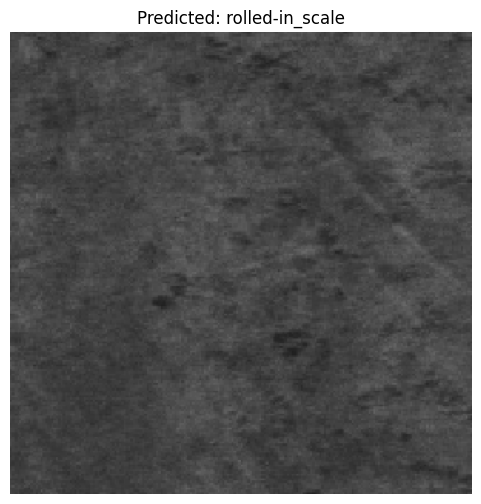


Prediction Probabilities:
crazing: 0.00%
inclusion: 0.00%
patches: 0.00%
pitted_surface: 0.00%
rolled-in_scale: 100.00%
scratches: 0.00%


In [102]:
# Example usage
predict_defect('/content/drive/MyDrive/ML Datasets/NEU-DET/validation/images/rolled-in_scale/rolled-in_scale_252.jpg')